<a href="https://colab.research.google.com/github/ganeshhep/JETS/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [126]:
!pip install uproot
!pip install fastjet

## Imports

In [121]:
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [ ]:
# Loading the data
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/task1.root"

Mounted at /content/drive


In [ ]:
tree = uproot.open(data_file)['tree']

In [ ]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | int32_t                  | AsDtype('>i4')
may_decay            | int8_t                   | AsDtype('int8')
isLepton             | int8_t                   | AsDtype('int8')
isbHadron            | int8_t                   | AsDtype('int8')
px                   | double                   | AsDtype('>f8')
py                   | double                   | AsDtype('>f8')
pz                   | double                   | AsDtype('>f8')
e                    | double                   | AsDtype('>f8')
pT                   | double                   | AsDtype('>f8')


In [ ]:
tree.num_entries # This is the sum total of number of all the particles obtained at the final state of all the events.

83815921

In [ ]:
table = tree.arrays(library = 'ak') # a list of dictionaries

In [119]:
def f(R) : # R is the radius parameter
  n_jets = [] # a list containing number of jets in each event
  n_bjets = [] # a list containing number of b-jets in each event
  jet_pT = [] # a list containing jets pT
  jet_eta = [] # a list containing jets eta
  t_mass = [] # mass of all the jets associated with top quark
  tbar_mass = [] # mass of all the jets associated with anti-top quark

  N = 25000 # number of events

  for n in range(N) : # taking upto N events
    bHadrons_list = [] # a list of b-hadrons in an event
    particles_list = [] # a list of particles in an event
    jets_list = [] # a list of jets in an event
    b_jets_list = [] # a list of b-jets in an event


    n_b = 0 # n is the number of b-jets in an event

    event_n = table[table['event'] == n]

    bHadrons = event_n[event_n['isbHadron'] == 1]
    stable_list = event_n[event_n['may_decay'] == 0]
    particles = stable_list[stable_list['isLepton'] == 0] # the list contains stable particles and no leptons are included

    for i in range(len(bHadrons)) :
      bHadron_p4 = PseudoJet(bHadrons[i]['px'], bHadrons[i]['py'], bHadrons[i]['pz'], bHadrons[i]['e'])
      bHadrons_list.append(bHadron_p4)

    for j in range(len(particles)) : # looping over the particles in an event
      part_p4 = PseudoJet(particles[j]['px'], particles[j]['py'], particles[j]['pz'], particles[j]['e'])
      particles_list.append(part_p4)

    # Applying clustering of particles with anti-kt algorithm
    cluster = ClusterSequence(particles_list, JetDefinition(antikt_algorithm, R))
    jet_set = sorted_by_pt(cluster.inclusive_jets(ptmin = 10.0)) # jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT) and pT > 10.0 GeV

    for z in range(len(jet_set)) : # looping over jets
      jet_p4 = jet_set[z]
      jets_list.append(jet_p4)
      jet_pT.append(jet_p4.pt())
      jet_eta.append(jet_p4.eta())

      # Identifying b-jets
      for l in range(len(bHadrons_list)) :
        b_hadron_p4 = bHadrons_list[l]
        del_R = ((jet_p4.eta() - b_hadron_p4.eta())**2 + (jet_p4.phi() - b_hadron_p4.phi())**2)**0.5
        if del_R < R :
          n_b += 1
          jets_list.remove(jet_p4)
          b_jets_list.append(jet_p4)
          break

    # jets_list now contains non b-jets set. From this list, we identify w-jets.
    sorted_b_jets_list = sorted_by_pt(b_jets_list)
    non_b_jets_list = jets_list

    if len(sorted_b_jets_list) > 1 and len(non_b_jets_list) > 3 :
      for m in range(2) :
        near_b_jets_list = []
        d_R_1 = 5000
        b_jet = sorted_b_jets_list[m]
        for s in range(len(non_b_jets_list)) :
          non_b_jet_1 = non_b_jets_list[s]
          delta_R_1 = ((b_jet.eta() - non_b_jet_1.eta())**2 + (b_jet.phi() - non_b_jet_1.phi())**2)**0.5
          if delta_R_1 < d_R_1 :
            d_R_1 = delta_R_1
            near_non_b_jet_1 = non_b_jet_1

        near_b_jets_list.append(near_non_b_jet_1)
        non_b_jets_list.remove(near_non_b_jet_1)

        d_R_2 = 5000

        for o in range(len(non_b_jets_list)) :
          non_b_jet_2 = non_b_jets_list[o]
          delta_R_2 = ((b_jet.eta() - non_b_jet_2.eta())**2 + (b_jet.phi() - non_b_jet_2.phi())**2)**0.5
          if delta_R_2 < d_R_2 :
            d_R_2 = delta_R_2
            near_non_b_jet_2 = non_b_jet_2

        near_b_jets_list.append(near_non_b_jet_2)
        non_b_jets_list.remove(near_non_b_jet_2)

        if m == 0 :
          t = near_b_jets_list[0] + near_b_jets_list[1] + b_jet
          t_mass.append(t.m())

        if m == 1 :
          tbar = near_b_jets_list[0] + near_b_jets_list[1] + b_jet
          tbar_mass.append(tbar.m())

    n_jets.append(len(jet_set))
    n_bjets.append(n_b)

  return n_jets, jet_pT, jet_eta, n_bjets, t_mass, tbar_mass

In [ ]:
R1 = f(0.8)

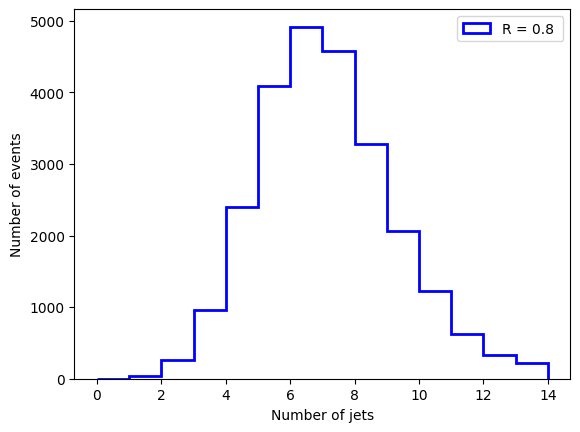

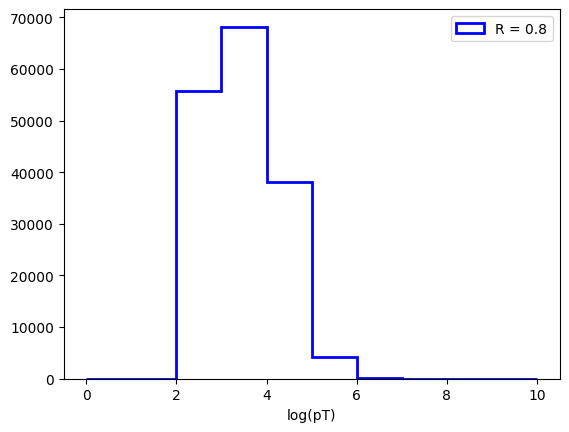

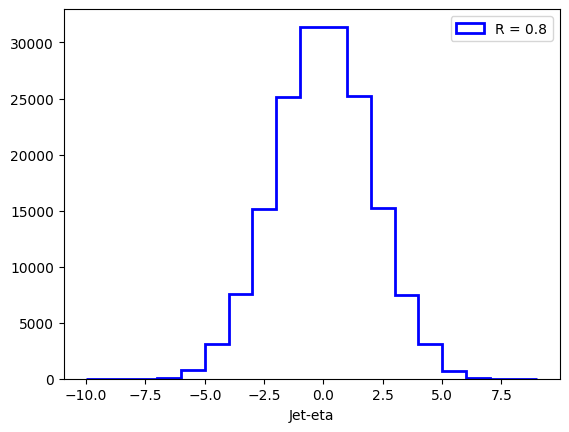

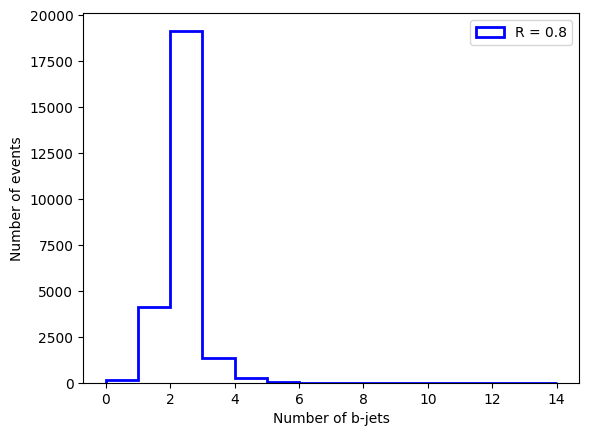

In [120]:
n_jets = R1[0]
plt.hist(n_jets, bins = np.arange(0, 15), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

jet_pT = R1[1]
plt.hist(np.log(jet_pT), bins = np.arange(0, 11), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("log(pT)")
plt.legend()
plt.show()

jet_eta = R1[2]
plt.hist(jet_eta, bins = np.arange(-10, 10), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Jet-eta")
plt.legend()
plt.show()

n_bjets = R1[3]
plt.hist(n_bjets, bins = np.arange(0, 15), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Number of b-jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

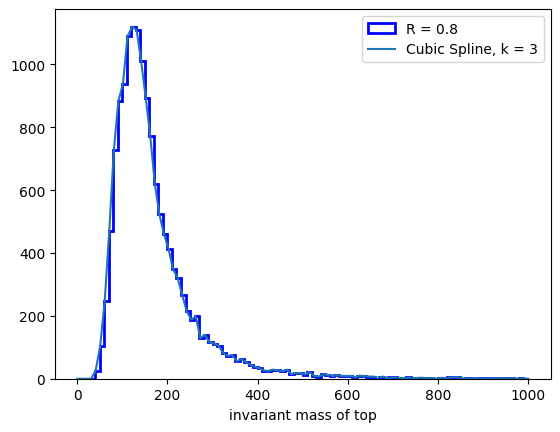

121.33333333333333 GeV
103.22400432034624


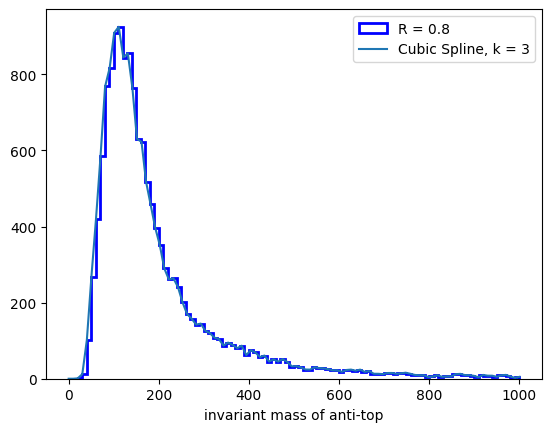

111.22222222222221 GeV
117.46242086490025


In [123]:
t_mass = R1[4]
tbar_mass = R1[5]
count_1, bins_1, patches_1 = plt.hist(t_mass, bins = np.arange(0, 1001, 10) , color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("invariant mass of top")

data_x_1 = np.linspace(0, 1001, len(count_1))
data_y_1 = count_1

us_1 = UnivariateSpline(data_x_1, data_y_1, s = 5)

us_1.set_smoothing_factor(0.05)
y2 = us_1(data_x_1)
plt.plot(data_x_1, y2)
plt.legend(['R = ' + str(0.8), 'Cubic Spline, k = 3'])
plt.show()

spline = UnivariateSpline(data_x_1, data_y_1 - np.max(data_y_1)/2, s=0)
r1, r2 = spline.roots() # find the roots
max_value = np.max(data_y_1)
ind = np.where(data_y_1 == max_value)

print(data_x_1[ind][0], "GeV")
print(r2 - r1)

count_2, bins_2, patches_2 = plt.hist(tbar_mass, bins = np.arange(0, 1001, 10), label = 'R = ' + str(0.8), color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("invariant mass of anti-top")
plt.legend()

data_x_2 = np.linspace(0, 1001, len(count_2))
data_y_2 = count_2

  #cs = CubicSpline(data_x,data_y)
us_2 = UnivariateSpline(data_x_2, data_y_2, s = 5)

plt.plot(data_x_2, us_2(data_x_2))
plt.legend(['R = ' + str(0.8), 'Cubic Spline, k = 3'])
plt.show()

spline_2 = UnivariateSpline(data_x_2, data_y_2 - np.max(data_y_2)/2, s=0)
s1, s2 = spline_2.roots() # find the roots
max_value_2 = np.max(data_y_2)
ind_2 = np.where(data_y_2 == max_value_2)

print(data_x_1[ind_2][0], "GeV")
print(s2 - s1)

In [ ]:
R2 = f(0.4)

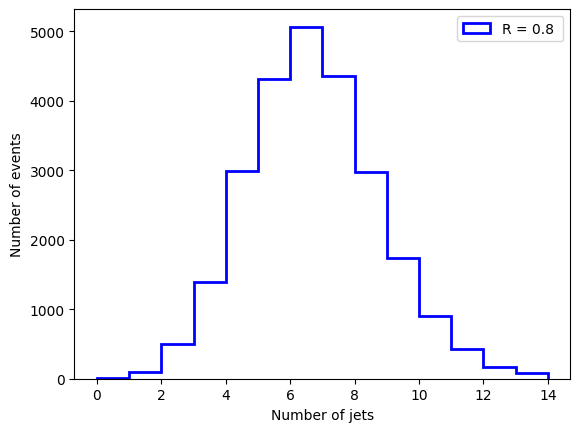

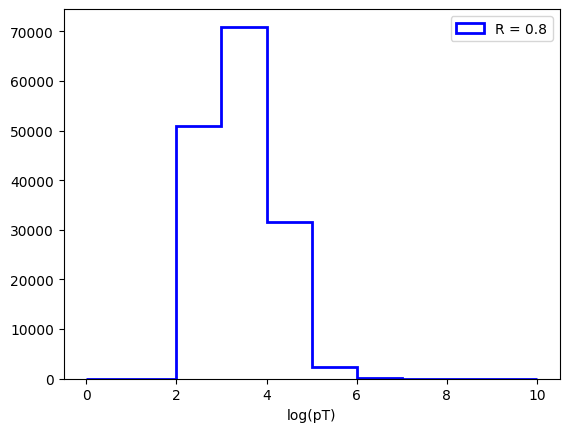

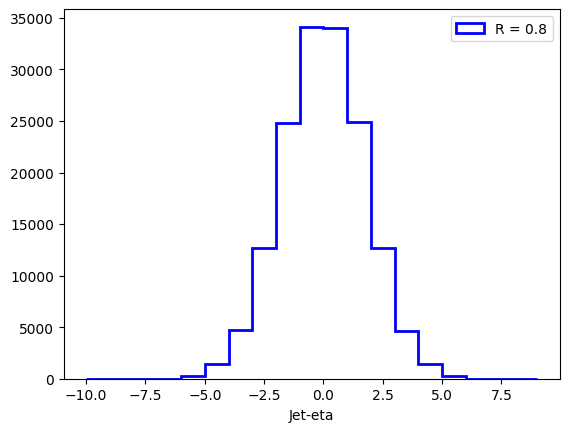

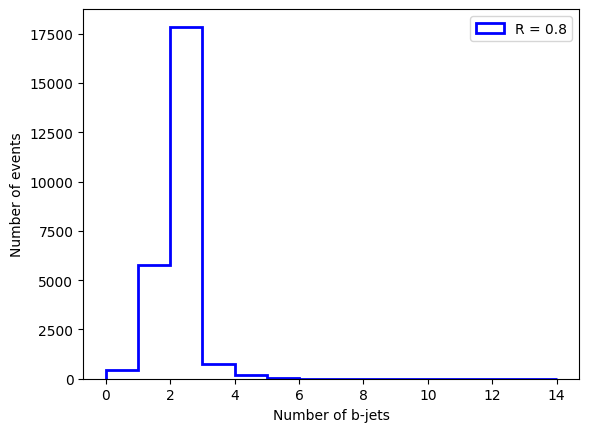

In [124]:
n_jets = R2[0]
plt.hist(n_jets, bins = np.arange(0, 15), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

jet_pT = R2[1]
plt.hist(np.log(jet_pT), bins = np.arange(0, 11), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("log(pT)")
plt.legend()
plt.show()

jet_eta = R2[2]
plt.hist(jet_eta, bins = np.arange(-10, 10), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Jet-eta")
plt.legend()
plt.show()

n_bjets = R2[3]
plt.hist(n_bjets, bins = np.arange(0, 15), label = 'R = 0.8', color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("Number of b-jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

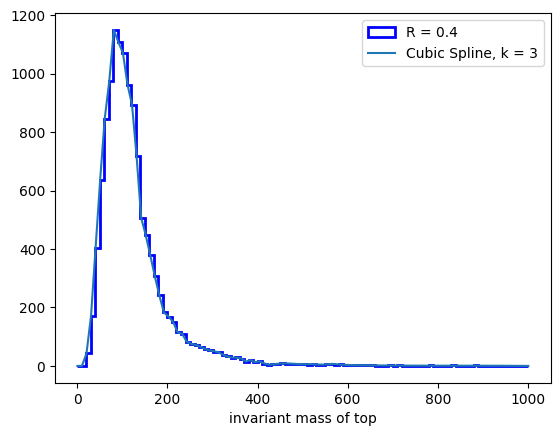

80.88888888888889 GeV
89.83001392712035


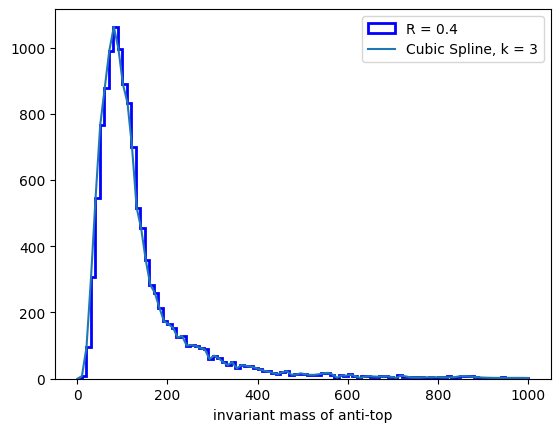

80.88888888888889 GeV
90.54614976466668


In [125]:
t_mass = R2[4]
tbar_mass = R2[5]
count_1, bins_1, patches_1 = plt.hist(t_mass, bins = np.arange(0, 1001, 10) , color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("invariant mass of top")

data_x_1 = np.linspace(0, 1001, len(count_1))
data_y_1 = count_1

  #cs = CubicSpline(data_x,data_y)
us_1 = UnivariateSpline(data_x_1, data_y_1, k = 3)

plt.plot(data_x_1, us_1(data_x_1))
plt.legend(['R = ' + str(0.4), 'Cubic Spline, k = 3'])
plt.show()

spline = UnivariateSpline(data_x_1, data_y_1 - np.max(data_y_1)/2, s=0)
r1, r2 = spline.roots() # find the roots
max_value = np.max(data_y_1)
ind = np.where(data_y_1 == max_value)

print(data_x_1[ind][0], "GeV")
print(r2 - r1)

count_2, bins_2, patches_2 = plt.hist(tbar_mass, bins = np.arange(0, 1001, 10), label = 'R = ' + str(0.8), color = 'blue', histtype = 'step', linewidth = 2.)
plt.xlabel("invariant mass of anti-top")
plt.legend()

data_x_2 = np.linspace(0, 1001, len(count_2))
data_y_2 = count_2

  #cs = CubicSpline(data_x,data_y)
us_2 = UnivariateSpline(data_x_2, data_y_2, k = 3)

plt.plot(data_x_2, us_2(data_x_2))
plt.legend(['R = ' + str(0.4), 'Cubic Spline, k = 3'])
plt.show()

spline_2 = UnivariateSpline(data_x_2, data_y_2 - np.max(data_y_2)/2, s=0)
s1, s2 = spline_2.roots() # find the roots
max_value_2 = np.max(data_y_2)
ind_2 = np.where(data_y_2 == max_value_2)

print(data_x_1[ind_2][0], "GeV")
print(s2 - s1)